In [1]:
#For this demonstration I use a lab notebook measured to be 12.7mm thick 

In [2]:
import sys
sys.path.append('/usr/local/lib')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.colors as mcol
import matplotlib.cm as cm
import math
import time
import pandas as pd
import json
import pyrealsense2 as rs
import cv2
from scipy import stats
from itertools import cycle
cycol = cycle('bgrcmk') #here I'm generating a list of colors I can plot

In [4]:
# Enabling Advanced Mode

DS5_product_ids = ["0AD1", "0AD2", "0AD3", "0AD4", "0AD5", "0AF6", "0AFE", "0AFF", "0B00", "0B01", "0B03", "0B07"]

def find_device_that_supports_advanced_mode() :
    ctx = rs.context()
    ds5_dev = rs.device()
    devices = ctx.query_devices();
    for dev in devices:
        if dev.supports(rs.camera_info.product_id) and str(dev.get_info(rs.camera_info.product_id)) in DS5_product_ids:
            if dev.supports(rs.camera_info.name):
                print("Found device that supports advanced mode:", dev.get_info(rs.camera_info.name))
            return dev
    raise Exception("No device that supports advanced mode was found")

try:
    dev = find_device_that_supports_advanced_mode()
    advnc_mode = rs.rs400_advanced_mode(dev)
    print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    # Loop until we successfully enable advanced mode
    while not advnc_mode.is_enabled():
        print("Trying to enable advanced mode...")
        advnc_mode.toggle_advanced_mode(True)
        # At this point the device will disconnect and re-connect.
        print("Sleeping for 5 seconds...")
        time.sleep(5)
        # The 'dev' object will become invalid and we need to initialize it again
        dev = find_device_that_supports_advanced_mode()
        advnc_mode = rs.rs400_advanced_mode(dev)
        print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    
except Exception as e:
    print(e)
pass

Found device that supports advanced mode: Intel RealSense D415
Advanced mode is enabled


In [5]:
# Loading presaved parameters 
# If I have another set of parameters I'd like to use already in the json format, I can skip the previous three blocks of code
#called d415_default.json on my laptop 
#called d415paramset_1.json on my desktop
with open("d415paramset_1.json") as json_data: #Json file to be loaded #notice How I am NOT using D415_params.json that I just created
    starting_params = json.load(json_data)
    starting_params=str(starting_params).replace("'", '\"') #IF YOU DON't DO THIS IT WILL NOT WORK with the librealsense sdk
    print(starting_params)

{"param-disableraucolor": "0", "param-disablesadcolor": "0", "param-disablesadnormalize": "0", "param-disablesloleftcolor": "0", "param-disableslorightcolor": "0", "param-lambdaad": "800", "param-lambdacensus": "26", "param-leftrightthreshold": "24", "param-maxscorethreshb": "2047", "param-medianthreshold": "500", "param-minscorethresha": "1", "param-neighborthresh": "7", "param-robbinsmonrodecrement": "10", "param-robbinsmonroincrement": "10", "param-secondpeakdelta": "325", "param-texturecountthresh": "0", "param-texturedifferencethresh": "0", "param-raumine": "1", "param-rauminn": "1", "param-rauminnssum": "3", "param-raumins": "1", "param-rauminw": "1", "param-rauminwesum": "3", "param-regionshrinku": "3", "param-regionshrinkv": "1", "param-regioncolorthresholdr": "0.05", "param-regioncolorthresholdg": "0.05", "param-regioncolorthresholdb": "0.05", "param-rsmdiffthreshold": "4", "param-rsmrauslodiffthreshold": "1", "param-rsmremovethreshold": "0.375", "param-usersm": "1", "param-sc

In [6]:
#Here I am getting the current values of all of the camera controls
current_ae_control=advnc_mode.get_ae_control()
current_census=advnc_mode.get_census()
current_color_control=advnc_mode.get_color_control()
current_color_correction=advnc_mode.get_color_correction()
current_depth_control=advnc_mode.get_depth_control()
current_depth_table=advnc_mode.get_depth_table()
current_hdad=advnc_mode.get_hdad()
current_rau_support_vector_control=advnc_mode.get_rau_support_vector_control()
current_rau_thresholds_control=advnc_mode.get_rau_thresholds_control()
current_rsm=advnc_mode.get_rsm()
current_slo_color_thresholds_control=advnc_mode.get_slo_color_thresholds_control()
current_slo_penalty_control=advnc_mode.get_slo_penalty_control()

In [7]:
#Here are some important parameters values

#Decent Defaults
paramvector=[400,9,9,0,0,0,0,0,.461914,.540039,.540039,.208008,-.332031,-.212891,-.212891,.68457,.930664,-.553711,-.553711,.458984,500,7,325,2,10,1,2047,0,0,65536,0,1000,0,0,0,800,26,1,1,3,1,1,3,0,0,51,51,51,4,63,0,1,72,72,72,60,105,70]
#Min Values
minparams=[400,1,1,0,0,0,0,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,800,26,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,1,1,1]
#Max Values
maxparams=[400,9,9,1,1,1,1,1,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,-1.99902,1023,1023,1023,2047,255,1023,4095,1023,4095,65536,65536,10000,1,512,0,800,26,7,3,7,3,7,15,4,4,1022,1022,1022,7.96875,168,1,3.96875,1022,1022,1022,511,511,511]

In [8]:
#I can set the value of any of the parametes by first changing a value within the advnc_mode.get object
current_ae_control.meanIntensitySetPoint=paramvector[0]

current_census.uDiameter=paramvector[1]
current_census.vDiameter=paramvector[2]

current_color_control.disableRAUColor=paramvector[3]
current_color_control.disableSADColor=paramvector[4]
current_color_control.disableSADNormalize=paramvector[5]
current_color_control.disableSLOLeftColor=paramvector[6]
current_color_control.disableSLORightColor=paramvector[7]

current_color_correction.colorCorrection1=paramvector[8]
current_color_correction.colorCorrection2=paramvector[9]
current_color_correction.colorCorrection3=paramvector[10]
current_color_correction.colorCorrection4=paramvector[11]
current_color_correction.colorCorrection5=paramvector[12]
current_color_correction.colorCorrection6=paramvector[13]
current_color_correction.colorCorrection7=paramvector[14]
current_color_correction.colorCorrection8=paramvector[15]
current_color_correction.colorCorrection9=paramvector[16]
current_color_correction.colorCorrection10=paramvector[17]
current_color_correction.colorCorrection11=paramvector[18]
current_color_correction.colorCorrection12=paramvector[19]

current_depth_control.deepSeaMedianThreshold=paramvector[20]
current_depth_control.deepSeaNeighborThreshold=paramvector[21]
current_depth_control.deepSeaSecondPeakThreshold=paramvector[22]
current_depth_control.lrAgreeThreshold=paramvector[23]
current_depth_control.minusDecrement=paramvector[24]
#current_depth_control.plusIncrement
current_depth_control.scoreThreshA=paramvector[25]
current_depth_control.scoreThreshB=paramvector[26]
current_depth_control.textureCountThreshold=paramvector[27]
current_depth_control.textureDifferenceThreshold=paramvector[28]

current_depth_table.depthClampMax=paramvector[29]
current_depth_table.depthClampMin=paramvector[30]
current_depth_table.depthUnits=paramvector[31]
current_depth_table.disparityMode=paramvector[32]
current_depth_table.disparityShift=paramvector[33]

current_hdad.ignoreSAD=paramvector[34]
current_hdad.lambdaAD=paramvector[35]
current_hdad.lambdaCensus=paramvector[36]

current_rau_support_vector_control.minEast=paramvector[37]
current_rau_support_vector_control.minNorth=paramvector[38]
current_rau_support_vector_control.minNSsum=paramvector[39]
current_rau_support_vector_control.minSouth=paramvector[40]
current_rau_support_vector_control.minWest=paramvector[41]
current_rau_support_vector_control.minWEsum=paramvector[42]
current_rau_support_vector_control.uShrink=paramvector[43]
current_rau_support_vector_control.vShrink=paramvector[44]

current_rau_thresholds_control.rauDiffThresholdBlue=paramvector[45]
current_rau_thresholds_control.rauDiffThresholdGreen=paramvector[46]
current_rau_thresholds_control.rauDiffThresholdRed=paramvector[47]

current_rsm.diffThresh=paramvector[48]
current_rsm.removeThresh=paramvector[49]
current_rsm.rsmBypass=paramvector[50]
current_rsm.sloRauDiffThresh=paramvector[51]

current_slo_color_thresholds_control.diffThresholdBlue=paramvector[52]
current_slo_color_thresholds_control.diffThresholdGreen=paramvector[53]
current_slo_color_thresholds_control.diffThresholdRed=paramvector[54]

current_slo_penalty_control.sloK1Penalty=paramvector[55]
current_slo_penalty_control.sloK1PenaltyMod1=paramvector[56]
current_slo_penalty_control.sloK1PenaltyMod2=paramvector[57]


In [9]:
#depth specific parameters
print(paramvector[20:29])
print(minparams[20:29])
print(maxparams[20:29])

[500, 7, 325, 2, 10, 1, 2047, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[1023, 1023, 1023, 2047, 255, 1023, 4095, 1023, 4095]


In [10]:
#constraining the parameter search around the default values yields greater percentage (several maginitudes) of reasonable images
def randomize_depth_control():
    set=[random.randint(450,550),random.randint(0,20),random.randint(300,350),random.randint(10,50),random.randint(0,20),random.randint(0,5),random.randint(1500,2500),random.randint(0,5),random.randint(0,5)]
    
    current_depth_control.deepSeaMedianThreshold=set[0]
    current_depth_control.deepSeaNeighborThreshold=set[1]
    current_depth_control.deepSeaSecondPeakThreshold=set[2]
    current_depth_control.lrAgreeThreshold=set[3]
    current_depth_control.minusDecrement=set[4]
    current_depth_control.scoreThreshA=set[5]
    current_depth_control.scoreThreshB=set[6]
    current_depth_control.textureCountThreshold=set[7]
    current_depth_control.textureDifferenceThreshold=set[8]
    advnc_mode.set_depth_control(current_depth_control)
    return set

In [11]:
# Function for Saving Parameters into a JSON file
def writeD415Json(path,filename,values):
    filepathname= './' + path + filename + '.json'
    parameters={}
    parameters["aux-param-autoexposure-setpoint"]=str(values[0])
    parameters["aux-param-colorcorrection1"]=str(values[1])
    parameters["aux-param-colorcorrection10"]=str(values[2])
    parameters["aux-param-colorcorrection11"]=str(values[3])
    parameters["aux-param-colorcorrection12"]=str(values[4]) 
    parameters["aux-param-colorcorrection2"]=str(values[5])
    parameters["aux-param-colorcorrection3"]=str(values[6])
    parameters["aux-param-colorcorrection4"]=str(values[7]) 
    parameters["aux-param-colorcorrection5"]=str(values[8])
    parameters["aux-param-colorcorrection6"]=str(values[9])
    parameters["aux-param-colorcorrection7"]=str(values[10])
    parameters["aux-param-colorcorrection8"]=str(values[11])
    parameters["aux-param-colorcorrection9"]=str(values[12])
    parameters["aux-param-depthclampmax"]=str(values[13])
    parameters["aux-param-depthclampmin"]=str(values[14])
    parameters["aux-param-disparityshift"]=str(values[15])
    parameters["controls-autoexposure-auto"]=str(values[16])
    parameters["controls-autoexposure-manual"]=str(values[17])
    parameters["controls-color-autoexposure-auto"]=str(values[18])
    parameters["controls-color-autoexposure-manual"]=str(values[19])
    parameters["controls-color-backlight-compensation"]=str(values[20])
    parameters["controls-color-brightness"]=str(values[21])
    parameters["controls-color-contrast"]=str(values[22])
    parameters["controls-color-gain"]=str(values[23])
    parameters["controls-color-gamma"]=str(values[24])
    parameters["controls-color-hue"]=str(values[25])
    parameters["controls-color-power-line-frequency"]=str(values[26])
    parameters["controls-color-saturation"]=str(values[27])
    parameters["controls-color-sharpness"]=str(values[28])
    parameters["controls-color-white-balance-auto"]=str(values[29])
    parameters["controls-color-white-balance-manual"]=str(values[30])
    parameters["controls-depth-gain"]=str(values[31])
    parameters["controls-depth-white-balance-auto"]=str(values[32])
    parameters["controls-laserpower"]=str(values[33])
    parameters["controls-laserstate"]=str(values[34])
    parameters["ignoreSAD"]=str(values[35])
    parameters["param-autoexposure-setpoint"]=str(values[36])
    parameters["param-censusenablereg-udiameter"]=str(values[37])
    parameters["param-censusenablereg-vdiameter"]=str(values[38])
    parameters["param-censususize"]=str(values[39])
    parameters["param-censusvsize"]=str(values[40])
    parameters["param-depthclampmax"]=str(values[41]) 
    parameters["param-depthclampmin"]=str(values[42]) 
    parameters["param-depthunits"]=str(values[43])
    parameters["param-disableraucolor"]=str(values[44])
    parameters["param-disablesadcolor"]=str(values[45])
    parameters["param-disablesadnormalize"]=str(values[46])
    parameters["param-disablesloleftcolor"]=str(values[47])
    parameters["param-disableslorightcolor"]=str(values[48]) 
    parameters["param-disparitymode"]=str(values[49])
    parameters["param-disparityshift"]=str(values[50])
    parameters["param-lambdaad"]=str(values[51])
    parameters["param-lambdacensus"]=str(values[52])
    parameters["param-leftrightthreshold"]=str(values[53]) 
    parameters["param-maxscorethreshb"]=str(values[54])
    parameters["param-medianthreshold"]=str(values[55])
    parameters["param-minscorethresha"]=str(values[56])
    parameters["param-neighborthresh"]=str(values[57])
    parameters["param-raumine"]=str(values[58])
    parameters["param-rauminn"]=str(values[59])
    parameters["param-rauminnssum"]=str(values[60])
    parameters["param-raumins"]=str(values[61])
    parameters["param-rauminw"]=str(values[62])
    parameters["param-rauminwesum"]=str(values[63])
    parameters["param-regioncolorthresholdb"]=str(values[64])
    parameters["param-regioncolorthresholdg"]=str(values[65])
    parameters["param-regioncolorthresholdr"]=str(values[66]) 
    parameters["param-regionshrinku"]=str(values[67])
    parameters["param-regionshrinkv"]=str(values[68])
    parameters["param-robbinsmonrodecrement"]=str(values[69])
    parameters["param-robbinsmonroincrement"]=str(values[70])
    parameters["param-rsmdiffthreshold"]=str(values[71])
    parameters["param-rsmrauslodiffthreshold"]=str(values[72]) 
    parameters["param-rsmremovethreshold"]=str(values[73]) 
    parameters["param-scanlineedgetaub"]=str(values[74])
    parameters["param-scanlineedgetaug"]=str(values[75]) 
    parameters["param-scanlineedgetaur"]=str(values[76]) 
    parameters["param-scanlinep1"]=str(values[77]) 
    parameters["param-scanlinep1onediscon"]=str(values[78]) 
    parameters["param-scanlinep1twodiscon"]=str(values[79])
    parameters["param-scanlinep2"]=str(values[80])
    parameters["param-scanlinep2onediscon"]=str(values[81])
    parameters["param-scanlinep2twodiscon"]=str(values[82])
    parameters["param-secondpeakdelta"]=str(values[83])
    parameters["param-texturecountthresh"]=str(values[84])
    parameters["param-texturedifferencethresh"]=str(values[85])
    parameters["param-usersm"]=str(values[86]) 
    parameters["param-zunits"]=str(values[87])
    
    with open(filepathname, 'w') as fp: #open file to write parameters
        json.dump(parameters, fp) # dump parameters into json


In [12]:
#values of some preset parameters.
values= [400, 0.461914, -0.553711, -0.553711, 0.0458984, 0.540039, 0.540039, 0.208008, -0.332031, -0.212891, -0.212891, 0.68457, 0.930664, 65536, 624, 53, "True", 33000, "True", 166, 0, 0 , 50, 64, 300, 0, 3, 64, 50, "True", 4600, 16, "False", 150, "on", 0, 400, 9, 9, 9, 9, 65536, 624, 901, 0, 0, 0, 0, 0, 0, 53, 800, 26, 24, 2047, 500, 1, 7, 1, 1, 3, 1, 1, 3, 0.0499022, 0.0499022, 0.0499022, 3, 1, 10, 10, 4, 1, 0.375, 72, 72, 72, 60, 105, 70, 342, 190, 130, 325, 0, 0, 1, 901] 

In [13]:
# Create file named D415_params.json and write the parameter values into that json file (Saved in the current path) 
filename='D415_params' 
path='./'
writeD415Json(path,filename,values)

In [14]:
#Recording Loop Initializations 

#camera specications
frame_width=848
frame_height=480
fps=90

#optimization specifications
number_of_frames_to_record=12000
background_length=50
background_chunk=int(number_of_frames_to_record/2) #I want to use 500 frames for recording the background

#open a file for apending binary data
file = open('pythondepthdata.bin', 'a+b')

# Configure depth stream
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, frame_width, frame_height, rs.format.z16, fps)
#config.enable_stream(rs.stream.color, frame_width, frame_height, rs.format.bgr8, fps)
advnc_mode.load_json(starting_params) #this is where I start with the Defualt Json

# Start streaming
cfg = pipeline.start(config)
dev = cfg.get_device()
depth_sensor = dev.first_depth_sensor()

In [15]:
start_of_loop=time.time()
saveddepthparams=[]
organizeddepthparams=[]
saveddepthparams.append(advnc_mode.get_depth_control())
organizeddepthparams.append(paramvector[20:29])
objectparamindex=0 #used to index the background parameters used in saveddepthparams list
tick=0; #keeping track of the number of loops the experiment has gone through 

#Main Recording Loop 

with open('pythondepthdata.bin','ab') as binarydata: #While the file called "pythonedpthdata.bin" is open for appending binary, 
    try:
        while tick<number_of_frames_to_record: 
            
            # Wait for a coherent pair of frames: depth and color
            frames=pipeline.wait_for_frames()
            depth_frame = frames.get_depth_frame()
        
            #First I want to record just the background with random params
            if (tick != 0) and tick<background_chunk: #avoid division by zero
                if tick%background_length==0: #every 100 frames I want to randomize the current depth control
                    cps=randomize_depth_control()
                    organizeddepthparams.append(cps)
                    saveddepthparams.append(advnc_mode.get_depth_control())
                    print("randomized background " + str(tick))
            
            # This is where I prompt the user to insert a calibration object
            if tick==background_chunk:
                object_id=input("Insert calibration object and enter data followed by the name of the object (format: YYMMDD_object)  ")
                
                
            #Next, I want to record an object in the same set of background parameters (that were randomly generated)        
            if background_chunk<=tick<=number_of_frames_to_record and tick%background_length==0:
                    advnc_mode.set_depth_control(saveddepthparams[objectparamindex])
                    saveddepthparams.append(advnc_mode.get_depth_control())
                    objectparamindex=objectparamindex+1
                    print("Changed object recording parameters to that of background-" + str(objectparamindex))             
            
            # Convert images to numpy arrays
            depth_image = np.asanyarray(depth_frame.get_data())
            #color_image = np.asanyarray(color_frame.get_data())
            depth_image.tofile(binarydata) #save data as binarydata (specified by the with open as line)
            
                
            tick=tick+1 

    finally:

        # Stop streaming
        pipeline.stop()
        end_of_loop=time.time() #end timer
        print("Time Elapsed = ", end_of_loop - start_of_loop)
        #serialized_string = advnc_mode.serialize_json() #getting the current parameters as a serialized string
        #as_json_object = json.loads(serialized_string) #loading the json object from the serialized string
        #json_used_in_experiment = str(as_json_object).replace("'", '\"') #converting object into string that can be printed
        #print("Final Parameters = ", json_used_in_experiment)

randomized background 50
randomized background 100
randomized background 150
randomized background 200
randomized background 250
randomized background 300
randomized background 350
randomized background 400
randomized background 450
randomized background 500
randomized background 550
randomized background 600
randomized background 650
randomized background 700
randomized background 750
randomized background 800
randomized background 850
randomized background 900
randomized background 950
randomized background 1000
randomized background 1050
randomized background 1100
randomized background 1150
randomized background 1200
randomized background 1250
randomized background 1300
randomized background 1350
randomized background 1400
randomized background 1450
randomized background 1500
randomized background 1550
randomized background 1600
randomized background 1650
randomized background 1700
randomized background 1750
randomized background 1800
randomized background 1850
randomized background

Changed object recording parameters to that of background-82
Changed object recording parameters to that of background-83
Changed object recording parameters to that of background-84
Changed object recording parameters to that of background-85
Changed object recording parameters to that of background-86
Changed object recording parameters to that of background-87
Changed object recording parameters to that of background-88
Changed object recording parameters to that of background-89
Changed object recording parameters to that of background-90
Changed object recording parameters to that of background-91
Changed object recording parameters to that of background-92
Changed object recording parameters to that of background-93
Changed object recording parameters to that of background-94
Changed object recording parameters to that of background-95
Changed object recording parameters to that of background-96
Changed object recording parameters to that of background-97
Changed object recording

In [16]:
#This is where I load the raw data and convert it into a numpy array
rawframes = np.fromfile('pythondepthdata.bin', dtype=np.uint16) #A highly efficient way of reading binary data with a known data-type, as well as parsing simply formatted text files. Data written using the tofile method can be read using this function.
frames = rawframes.reshape(-1, frame_height, frame_width) #.reshape simply restructures data into dimensions of your choosing. -1 means find the number of segments that structures the data into the dimnesions shown afterwards
del rawframes

In [17]:
number_of_frames,video_height,video_width=frames.shape[0],frames.shape[1],frames.shape[2];
#set number of frames equal to the first element in reshaped.shape
#set video height to the second element in reshaped.shape
#set video width to the third element in reshaped.shape
print('The shape of the video is {0} by {1} and it has {2} frames'.format(video_height,video_width,number_of_frames))
#note that the nubmers below are one greater than the actual indices that exist
#there is no reshaped[number_of_frames,height,width], the last frame is reshaped[number_of_frames-1,height-1,width-1]

The shape of the video is 480 by 848 and it has 12000 frames


In [18]:
#Testing Analysis For Every Parameter Set

mean_results=[]
median_results=[]
variance_results=[]

for i in range(int(number_of_frames/int(2*background_length))):

    picked_frame=int(((background_length*i)+background_chunk+(background_length/2))) #Picked frames greater than the background chunk should show image of object,every 100 frames use different parameters
    frame_of_interest=frames[picked_frame]
    #know your background 
    background_low_bounds=int(((picked_frame-(picked_frame%background_length))-background_chunk))
    background_high_bounds=int(((picked_frame-(picked_frame%background_length))-background_chunk)+(background_length-1))
    backgroundmean=np.median(frames[background_low_bounds:background_high_bounds], axis=0) #probably safer to do median since the noise is known to mean gaussian
    backgroundvariance=np.var(frames[background_low_bounds:background_high_bounds], axis=0)

    #if the difference between the background and the frame is greater than expected, it's probably our object! 
    #note that I arbitrarily pick 5 stdeviations away, it's worth knowing if the noise is actually gaussian
    backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (10*np.sqrt(backgroundvariance)) #if its 5 standard its NOISE
    #we expect positive values for high differences. make them stay by multiplying by 1
    backgroundmultiplier[backgroundmultiplier>0]=1
    #we expect negative values or no change for small differences. probably just noise, get rid of them by multiplying by 0
    backgroundmultiplier[backgroundmultiplier<=0]=0
    #apply our expectations to the matrix

    frame_of_interest_backgroundsubtracted=np.multiply(np.subtract(frame_of_interest,backgroundmean),-1) #subtract the background mean and then multiply result by negative 1 since the camera counts distance away 
    frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest_backgroundsubtracted,backgroundmultiplier) #pixels that arent significantly different are considered background 
    frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted<0]=0 #everything less than 0 IS zero
    #frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest_backgroundsubtracted,1) #go from mm to something else by mlitplying by something other than 1
    frame_of_interest_backgroundsubtracted=np.rint(frame_of_interest_backgroundsubtracted) #makes everything an integer

    #basic stats
    object_median=np.median(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted>0])
    object_mean=np.mean(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0])
    object_variance=np.var(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0])
    #objectsigma=np.sqrt(objectvariance)
    
    mean_results.append(object_mean)
    median_results.append(object_median)
    variance_results.append(object_variance)

    #Plotting background-subtracted image
    #fig=plt.figure(figsize=(10,10))
    #plt.imshow(frame_of_interest_backgroundsubtracted)
    #plt.clim(object_median-100,object_median+100)
    #fig.savefig(object_id + '_%d.png'%i)

    #same image with jet color bar
    fig2=plt.figure(figsize=(8,8))
    plt.colorbar(plt.imshow(frame_of_interest_backgroundsubtracted,cmap='jet'))
    plt.clim(0,object_median+100) #starting at 0 instead of -100
    fig2.savefig(object_id + '_jet_%d.png'%i)

    #show the stats
    print('mean is %f' %object_mean)
    print('median is %f' %object_median)
    print('variance is %f' %object_variance)
    
    #plt.close(fig)
    plt.close(fig2)
    


mean is 97.240806
median is 53.000000
variance is 26101.020536
mean is 100.085008
median is 53.000000
variance is 27485.410465
mean is 92.924138
median is 53.000000
variance is 23839.005305
mean is 98.889046
median is 54.000000
variance is 26923.302402
mean is 94.684725
median is 54.000000
variance is 24637.499113
mean is 92.242964
median is 54.000000
variance is 23471.549814
mean is 94.138440
median is 54.000000
variance is 24373.653884
mean is 98.029368
median is 54.000000
variance is 26160.526856
mean is 95.175010
median is 54.000000
variance is 24819.962633
mean is 99.880018
median is 54.000000
variance is 27053.645698
mean is 92.554106
median is 54.000000
variance is 23373.511923
mean is 93.087467
median is 54.000000
variance is 23547.466258
mean is 91.739144
median is 54.000000
variance is 22889.148614
mean is 90.055592
median is 54.000000
variance is 22094.120144
mean is 95.370135
median is 54.000000
variance is 24747.927107
mean is 104.208207
median is 54.000000
variance is 291

86.4480660861
54.0
20468.3306789


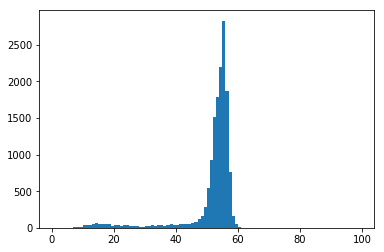

minusDecrement: 0, deepSeaMedianThreshold: 504, scoreThreshA: 0, scoreThreshB: 2458, textureDifferenceThreshold: 2, textureCountThreshold: 5, deepSeaSecondPeakThreshold: 316, deepSeaNeighborThreshold: 12, lrAgreeThreshold: 50


In [19]:
#plot histogram of the pixels with least variance
minvarindex=variance_results.index(min(variance_results)) #index of min variance image

picked_frame=int(((background_length*minvarindex)+background_chunk+(background_length/2))) #Picked frames greater than the background chunk should show image of object,every 100 frames use different parameters
frame_of_interest=frames[picked_frame]
#know your background 
background_low_bounds=int(((picked_frame-(picked_frame%background_length))-background_chunk))
background_high_bounds=int(((picked_frame-(picked_frame%background_length))-background_chunk)+(background_length-1))
backgroundmean=np.median(frames[background_low_bounds:background_high_bounds], axis=0) #probably safer to do median since the noise is known to mean gaussian
backgroundvariance=np.var(frames[background_low_bounds:background_high_bounds], axis=0)

#if the difference between the background and the frame is greater than expected, it's probably our object! 
#note that I arbitrarily pick 5 stdeviations away, it's worth knowing if the noise is actually gaussian
backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (10*np.sqrt(backgroundvariance)) #if its 5 standard its NOISE
#we expect positive values for high differences. make them stay by multiplying by 1
backgroundmultiplier[backgroundmultiplier>0]=1
#we expect negative values or no change for small differences. probably just noise, get rid of them by multiplying by 0
backgroundmultiplier[backgroundmultiplier<=0]=0
#apply our expectations to the matrix

frame_of_interest_backgroundsubtracted=np.multiply(np.subtract(frame_of_interest,backgroundmean),-1) #subtract the background mean and then multiply result by negative 1 since the camera counts distance away 
frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest_backgroundsubtracted,backgroundmultiplier) #pixels that arent significantly different are considered background 
frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted<0]=0 #everything less than 0 IS zero
#frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest_backgroundsubtracted,1) #go from mm to something else by mlitplying by something other than 1
frame_of_interest_backgroundsubtracted=np.rint(frame_of_interest_backgroundsubtracted) #makes everything an integer

#basic stats
object_median=np.median(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted>0])
object_mean=np.mean(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0])
object_variance=np.var(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0])
print(object_mean)
print(object_median)
print(object_variance)
plt.hist(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0],bins=range(1,100))
plt.show()
print(saveddepthparams[int((background_low_bounds/background_length))]) #print the depth parameters that led to this histogram

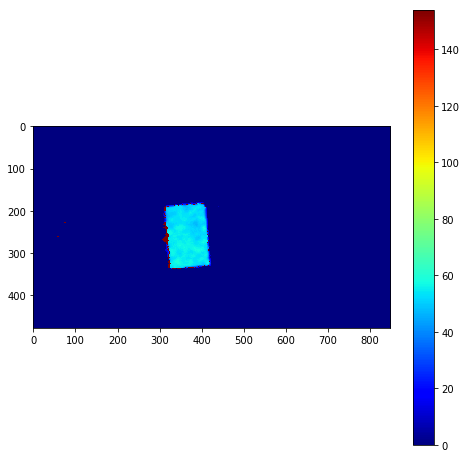

In [20]:
plt.figure(figsize=(8,8))
plt.colorbar(plt.imshow(frame_of_interest_backgroundsubtracted,cmap='jet'))
plt.clim(0,object_median+100) #starting at 0 instead of -100

In [21]:
print(variance_results)

[26101.020536138458, 27485.410464674733, 23839.005305453979, 26923.30240157451, 24637.49911295022, 23471.549814076239, 24373.653884018899, 26160.526856001386, 24819.962633086168, 27053.64569809203, 23373.51192270355, 23547.466257809901, 22889.148613527035, 22094.120143996963, 24747.92710654777, 29117.073535654949, 39223.676665646759, 20638.533657195072, 25564.238317245847, 22264.911070862094, 25007.754347687904, 26006.901775846873, 26010.920257264581, 23909.040182810095, 30267.271627404007, 23114.695659038123, 23420.892493923151, 23444.918749996315, 25382.58045688858, 24122.152982651973, 22888.392173671135, 23389.657557447172, 25093.541378143822, 33209.323925377292, 23511.816950214547, 27701.463683530903, 31039.705958257669, 22480.912390519268, 31595.27322838558, 21865.091698144683, 24893.33235969178, 31726.395100474056, 25425.639441411462, 22194.207621521826, 31763.230781441725, 24824.339439640153, 22841.557092743613, 23777.182550051431, 23698.332423183972, 24645.023532675059, 37947.6

In [22]:
print(organizeddepthparams)

[[500, 7, 325, 2, 10, 1, 2047, 0, 0], [465, 20, 347, 23, 9, 4, 1936, 1, 2], [545, 6, 303, 36, 3, 2, 2101, 4, 4], [515, 19, 334, 28, 12, 4, 1859, 1, 4], [528, 8, 338, 42, 0, 1, 2295, 3, 2], [460, 14, 315, 46, 12, 0, 1693, 5, 1], [468, 19, 313, 24, 5, 0, 2359, 1, 3], [522, 14, 302, 23, 0, 2, 1742, 3, 0], [456, 10, 324, 36, 1, 5, 2466, 2, 2], [452, 19, 341, 27, 5, 0, 2107, 2, 4], [462, 3, 323, 41, 7, 1, 1535, 3, 3], [541, 15, 328, 34, 8, 3, 1662, 5, 4], [505, 3, 306, 47, 14, 0, 2080, 3, 1], [466, 18, 308, 49, 13, 1, 2165, 3, 5], [500, 19, 337, 32, 14, 3, 2085, 1, 4], [462, 5, 323, 17, 10, 3, 1791, 1, 0], [482, 12, 328, 10, 7, 0, 2437, 2, 3], [482, 19, 317, 43, 3, 4, 1805, 4, 0], [474, 17, 347, 36, 17, 5, 1681, 0, 3], [486, 8, 307, 35, 8, 5, 2447, 1, 1], [525, 12, 345, 35, 12, 2, 2084, 5, 4], [508, 12, 309, 20, 11, 3, 2245, 5, 2], [473, 6, 333, 22, 11, 4, 2144, 2, 5], [484, 11, 334, 35, 2, 4, 2297, 0, 1], [467, 14, 327, 16, 9, 4, 2450, 1, 4], [458, 3, 306, 37, 2, 0, 2371, 1, 2], [511, 17, 

In [23]:
#correlation between parameter a and variance. a is the 3rd depth parameter
a=[]
for x in range(len(organizeddepthparams)):
    a.append(organizeddepthparams[x][0])
b=[]
for x in range(len(organizeddepthparams)):
    b.append(organizeddepthparams[x][1])
c=[]
for x in range(len(organizeddepthparams)):
    c.append(organizeddepthparams[x][2])
d=[]
for x in range(len(organizeddepthparams)):
    d.append(organizeddepthparams[x][3])
e=[]
for x in range(len(organizeddepthparams)):
    e.append(organizeddepthparams[x][4])
f=[]
for x in range(len(organizeddepthparams)):
    f.append(organizeddepthparams[x][5])
g=[]
for x in range(len(organizeddepthparams)):
    g.append(organizeddepthparams[x][6])
h=[]
for x in range(len(organizeddepthparams)):
    h.append(organizeddepthparams[x][7])
i=[]
for x in range(len(organizeddepthparams)):
    i.append(organizeddepthparams[x][8])

In [24]:
a=np.divide(np.subtract(a,450),(550-450))
b=np.divide(np.subtract(b,0),20)
c=np.divide(np.subtract(c,300),(350-300))
d=np.divide(np.subtract(d,10),(50-10))
e=np.divide(np.subtract(e,0),20)
f=np.divide(np.subtract(f,0),5)
g=np.divide(np.subtract(g,1500),(2500-1500))
h=np.divide(np.subtract(h,0),5)
i=np.divide(np.subtract(i,0),5)

In [25]:
mask=np.isfinite(variance_results) #find the nans
variance_results=np.sqrt(variance_results) #square root variance

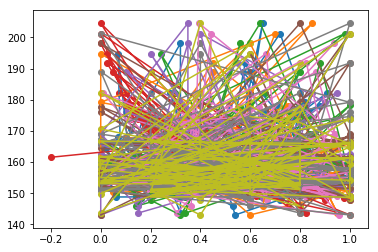

In [26]:
plt.scatter(a[mask],variance_results[mask])
plt.scatter(b[mask],variance_results[mask])
plt.scatter(c[mask],variance_results[mask])
plt.scatter(d[mask],variance_results[mask])
plt.scatter(e[mask],variance_results[mask])
plt.scatter(f[mask],variance_results[mask])
plt.scatter(g[mask],variance_results[mask])
plt.scatter(h[mask],variance_results[mask])
plt.scatter(i[mask],variance_results[mask])

plt.plot(a[mask],variance_results[mask])
plt.plot(b[mask],variance_results[mask])
plt.plot(c[mask],variance_results[mask])
plt.plot(d[mask],variance_results[mask])
plt.plot(e[mask],variance_results[mask])
plt.plot(f[mask],variance_results[mask])
plt.plot(g[mask],variance_results[mask])
plt.plot(h[mask],variance_results[mask])
plt.plot(i[mask],variance_results[mask])

plt.show()

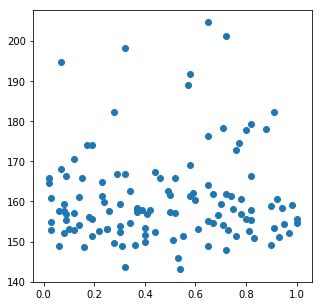

[   2.25910044  159.621483  ]


In [49]:
paramplt=plt.figure(figsize=(5,5))
plt.scatter(a[mask],variance_results[mask])
plt.show()
paramplt.savefig("param20.png")
print(np.polyfit(a[mask],variance_results[mask],1))

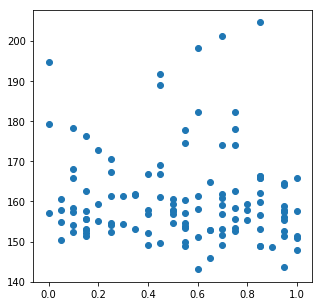

[  -2.95599598  162.27772385]


In [48]:
paramplt=plt.figure(figsize=(5,5))
plt.scatter(b[mask],variance_results[mask])
plt.show()
paramplt.savefig("param21.png")
print(np.polyfit(b[mask],variance_results[mask],1))

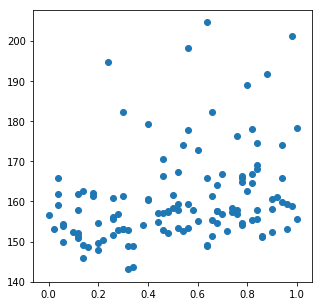

[  12.34759877  154.20308158]


In [47]:
paramplt=plt.figure(figsize=(5,5))
plt.scatter(c[mask],variance_results[mask])
plt.show()
paramplt.savefig("param22.png")
print(np.polyfit(c[mask],variance_results[mask],1))

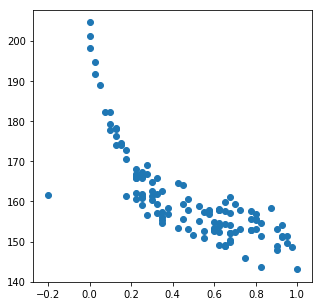

[ -32.93771927  176.42156362]


In [41]:
paramplt=plt.figure(figsize=(5,5))
plt.scatter(d[mask],variance_results[mask])
plt.show()
paramplt.savefig("param23.png")
print(np.polyfit(d[mask],variance_results[mask],1))

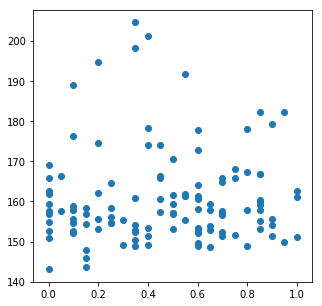

[   1.70454526  159.90687094]


In [42]:
paramplt=plt.figure(figsize=(5,5))
plt.scatter(e[mask],variance_results[mask])
plt.show()
paramplt.savefig("param24.png")
print(np.polyfit(e[mask],variance_results[mask],1))

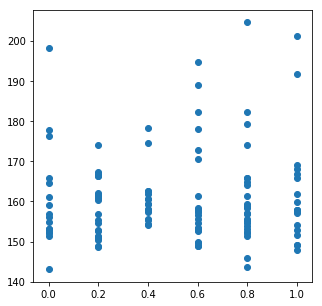

[   2.49136168  159.38583779]


In [43]:
paramplt=plt.figure(figsize=(5,5))
plt.scatter(f[mask],variance_results[mask])
plt.show()
paramplt.savefig("param25.png")
print(np.polyfit(f[mask],variance_results[mask],1))

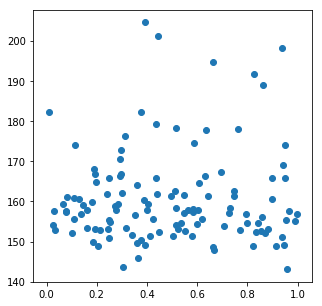

[   1.52712419  159.94581724]


In [44]:
paramplt=plt.figure(figsize=(5,5))
plt.scatter(g[mask],variance_results[mask])
plt.show()
paramplt.savefig("param26.png")
print(np.polyfit(g[mask],variance_results[mask],1))

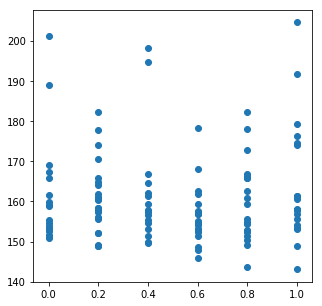

[   1.0141075   160.18674892]


In [45]:
paramplt=plt.figure(figsize=(5,5))
plt.scatter(h[mask],variance_results[mask])
plt.show()
paramplt.savefig("param27.png")
print(np.polyfit(h[mask],variance_results[mask],1))

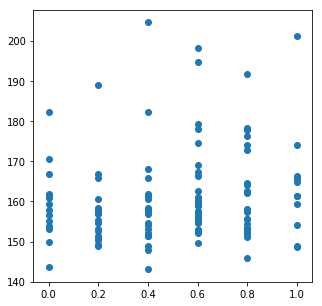

[   6.21972807  157.55283999]


In [46]:
paramplt=plt.figure(figsize=(5,5))
plt.scatter(i[mask],variance_results[mask])
plt.show()
paramplt.savefig("param28.png")
print(np.polyfit(i[mask],variance_results[mask],1))

In [40]:
import pickle

x=open("brute_force_results_%s"%object_id,'wb')
pickle.dump([mean_results,median_results,variance_results],x)
x.close()

In [37]:
#already looks like parameters d, h and i effect the variance!